# This script generates a video of general hive visualisation

## Imports

In [1]:
import multiprocessing, cv2, os, sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
sys.path.append(os.path.abspath('ABCThermalPlots'))
sys.path.append(os.path.abspath('ABCImaging'))
from libvisu import *
from ABCImaging.libimage import fetchImagesPaths
from ABCImaging.VideoManagment.videolib import initVideoWriter
from InfluxDBInterface.libdb import download_data_DB, removeTmpOutliers
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide width for display
pd.set_option('display.colheader_justify', 'center')  # Align column headers
from dask.distributed import Client
# Start a client using all CPUs of this machine
client = Client()
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/scheduler-npghbb0f', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-rpo6007y', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-yw9zuete', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-l0te8slc', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-4tamz2u4', purging
INFO:distributed.

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52076,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52091,Total threads: 3
Dashboard: http://127.0.0.1:52093/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:52079,


## Configuration

In [2]:
# ==== GENERAL SETTINGS ====
download_data = True    # Set to True to download data from InfluxDB, False to use data stored locally
hive_nb = 2             # Hive number to process (1 or 2 for OH, 3 for BH and 0 for debugging)
t_res = "1min"          # Image time resolution. Change only if images are not taken every minute. Use frame_drop to keep only some frames, not this.
rootpath_imgs = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/24.11-25.01_metabolism_OH/Images/'     # For images
first_dt = pd.to_datetime("241206-120000Z", format='%y%m%d-%H%M%S%z')
last_dt = pd.to_datetime("241213-100000Z", format='%y%m%d-%H%M%S%z')
frame_drop = 25          # We keep 1 frame every frame_drop frames. Put one to keep all frames.
fps = 20                # FPS of the output video

thermal_shift = None # The thermal shift to apply (aSensing3, aSensing3.5, etc.). Use None for no shift
show_co2 = False        # Set to True to show CO2 data on the video
show_htrs = True       # Set to True to show heater data on the video

dest = "outputVideos/"

verbose = True          # Set to True to print progress messages

# ==== LOCAL DATA CONFIGURATION ====
if not download_data:
    data_path = 'data/2025-10-06_13-18_influxdb_data.csv' # Path to the local .csv or .dat file containing the CO2, htr and tmp data

# ==== DATA DOWNLOAD CONFIGURATION ====
if download_data:
    bucket = 'winter_exp' # InfluxDB bucket to download data from

## Main code

### Image fetching

In [3]:
# Get the target dt (for which we need an image, data, etc.)
datetimes = pd.date_range(start=first_dt, end=last_dt, freq=t_res)
datetimes = datetimes[::frame_drop]

# Print the number of dts considered
print(f"Number of datetimes considered: {len(datetimes)}")

imgs_paths = fetchImagesPaths(rootpath_imgs, datetimes, hive_nb)
print(f"Found {len(imgs_paths)} images for hive {hive_nb} between {first_dt} and {last_dt}.")

Number of datetimes considered: 399
Found 399 images for hive 2 between 2024-12-06 12:00:00+00:00 and 2024-12-13 10:00:00+00:00.


### Htr, co2 and tmp data fetching

In [4]:
if download_data:
    data_res = int(t_res[0]) * 60
    filters = {'hive_num': str(hive_nb),
               'measurement': ['tmp']}
    if show_co2:
        filters['measurement'].append('co2')  # Add CO2 sensor data if needed
    if show_htrs:
        filters['measurement'].append('htr')  # Add heater data if needed

    # We take a higher frequency than needed to perform filtering
    hive_data = download_data_DB(bucket, first_dt, last_dt, data_res, filters, verbose=verbose) # Restricted to our time frame and hive
    
else:
    data_path = os.path.abspath(data_path)          # Absolute path to the data
    hive_data = extractData(data_path, hive_nb, datetimes, verbose=False) # Restricted to our time frame and hive
print(hive_data.head())

Executing query:

    from(bucket: "winter_exp")
      |> range(start: 2024-12-06T11:59:00Z, stop: 2024-12-13T10:00:00Z)
      |> filter(fn: (r) => r["_measurement"] == "tmp" or r["_measurement"] == "htr")
      |> filter(fn: (r) => r["hive_num"] == "2")
      |> aggregateWindow(every: 60s, fn: last, createEmpty: false)
      |> yield(name: "last")
    
                                    _start                    _stop             _value     _field   _measurement actuator_instance board_id geo_loc hive_num inhive_loc          mcu_uuid          phys_loc  rpi_num   serial_id    valid
_time                                                                                                                                                                                                                                    
2024-12-06 12:00:00+00:00 2024-12-06 11:59:00+00:00 2024-12-13 10:00:00+00:00  19.359380   avg_temp      htr             h00         abc02    EPFL      2       upper    2191218

### tmp fetching

In [5]:
upper, lower = generateThermalDF(hive_data)   # Only tmp data, in a format that can be used by ThermalFrame

# Cleaning step of all tmp data: remove outliers
for df in [upper, lower]:
    for col in df.columns:
        df[col] = removeTmpOutliers(df[col], allowed_variation=2.0)

# Restrain both dataframes to the target datetimes
upper = upper[upper.index.isin(datetimes)]
lower = lower[lower.index.isin(datetimes)]

# Seek the max and min values of the tmp data, in both upper and lower hives
# max_temp = max(upper.max().max(), lower.max().max())
# min_temp = min(upper.min().min(), lower.min().min())

max_temp = np.nanmax([upper.to_numpy(), lower.to_numpy()])
min_temp = np.nanmin([upper.to_numpy(), lower.to_numpy()])
print("Max temperature in the selected time range: ", max_temp)
print("Min temperature in the selected time range: ", min_temp)
print(lower)

Max temperature in the selected time range:  31.8125
Min temperature in the selected time range:  8.0625
                              t00        t01        t02        t03        t04        t05        t06        t07        t08        t09        t10        t11        t12        t13        t14        t15        t16        t17        t18        t19        t20        t21        t22        t23        t24        t25        t26        t27        t28        t29        t30        t31        t32        t33        t34        t35        t36        t37        t38        t39        t40        t41        t42        t43        t44        t45        t46        t47        t48        t49        t50        t51        t52        t53        t54        t55        t56        t57        t58        t59        t60        t61        t62        t63   
_time                                                                                                                                                                

### Metabolic data fetching

In [6]:
if show_co2:
    # Now we fetch the metabolic data
    co2_data =generateMetabolicDF(hive_data)
    # Restrain co2_data to the target datetimes
    co2_data = co2_data[co2_data.index.isin(datetimes)]
    print(co2_data)
else:
    co2_data = pd.DataFrame()  # Empty DataFrame if CO2 data is not to be shown

### htr fetching

In [7]:
if show_htrs:
    # Alternative used now:
    upper_htr = hive_data[(hive_data["inhive_loc"] == "upper") & (hive_data["_measurement"] == "htr")]
    lower_htr = hive_data[(hive_data["inhive_loc"] == "lower") & (hive_data["_measurement"] == "htr")]
    # Drop the _measurement column
    upper_htr.drop(columns=["_measurement", "_start", "_stop"], inplace=True)
    lower_htr.drop(columns=["_measurement", "_start", "_stop"], inplace=True)

    # Restrain both dataframes to the target datetimes
    upper_htr = upper_htr[upper_htr.index.isin(datetimes)]
    lower_htr = lower_htr[lower_htr.index.isin(datetimes)]
    print(upper_htr) # TODO: it is missing columns. Check why, and how we can avoid it from breaking the automation part at the bottom of the nb !!
    print(lower_htr)
else:
    upper_htr = pd.DataFrame()  # Empty DataFrame if htr data is not to be shown
    lower_htr = pd.DataFrame()  # Empty DataFrame if htr data is not to be shown

                            _value    _field   actuator_instance board_id geo_loc hive_num inhive_loc          mcu_uuid          phys_loc  rpi_num   serial_id    valid
_time                                                                                                                                                                  
2024-12-06 12:00:00+00:00  19.35938   avg_temp         h00         abc02    EPFL      2       upper    2191218169584597824190002   bass       1     /dev/ttyACM0  True 
2024-12-06 12:00:00+00:00   0.00000        obj         h03         abc02    EPFL      2       upper    2191218169584597824190002   bass       1     /dev/ttyACM0  True 
2024-12-06 12:00:00+00:00   0.00000  is_active         h03         abc02    EPFL      2       upper    2191218169584597824190002   bass       1     /dev/ttyACM0  True 
2024-12-06 12:00:00+00:00  16.60156   avg_temp         h03         abc02    EPFL      2       upper    2191218169584597824190002   bass       1     /dev/ttyACM0

/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/ipykernel_95615/3483045410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_htr.drop(columns=["_measurement", "_start", "_stop"], inplace=True)
/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/ipykernel_95615/3483045410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_htr.drop(columns=["_measurement", "_start", "_stop"], inplace=True)


### Frame generation

In [8]:
def generate_frame(dt:pd.Timestamp, contours:list = []):
    """Generate a single annotated frame for the given datetime.

    Args:
        dt (pd.Timestamp): The datetime for which to generate the frame.
    Returns:
        np.ndarray: The generated annotated frame as an image array.
    """

    # Fetch the corresponding image paths
    _imgs_paths = imgs_paths.loc[dt].to_numpy()
    imgs_names = [str(_imgs_paths[j]).split("/")[-1][:-4] for j in range(len(_imgs_paths))]
    # Read the images using cv2
    current_imgs = []
    for _img_path in _imgs_paths:
        if _img_path is not None:
            img = cv2.imread(_img_path, cv2.IMREAD_GRAYSCALE)
            current_imgs.append(img)
        else:
            current_imgs.append(None)
    
    # Thermal data
    try:
        upper_tf = ThermalFrame(upper.loc[dt].to_numpy())
    except (NoValidSensors, KeyError):
        upper_tf = None

    try:
        lower_tf = ThermalFrame(lower.loc[dt].to_numpy())
    except (NoValidSensors, KeyError):
        lower_tf = None

    # Metabolic data
    if dt in co2_data.index:
        metabolic_df = co2_data.loc[dt]
    else:
        metabolic_df = None

    # Lower heater
    if dt in lower_htr.index:
        lower_htr_row = lower_htr.loc[dt]
    else:
        lower_htr_row = None

    # Upper heater
    if dt in upper_htr.index:
        upper_htr_row = upper_htr.loc[dt]
    else:
        upper_htr_row = None
    
    hs = Hive(dt, current_imgs, False, imgs_names, upper_tf, lower_tf, metabolic_df, upper_htr_row, lower_htr_row, hive_nb=hive_nb)
    if thermal_shift is not None:
        from libvisu import thermal_shifts
        hs.setThermalShifts(thermal_shifts[thermal_shift][hive_nb])
    snapshot = hs.snapshot(v_max=max_temp, v_min=min_temp, contours=contours, annotate_contours=True, thermal_transparency=0.4, check_validity=False, annotate_names=False, use_cet_time=True)

    return snapshot

### Plotting

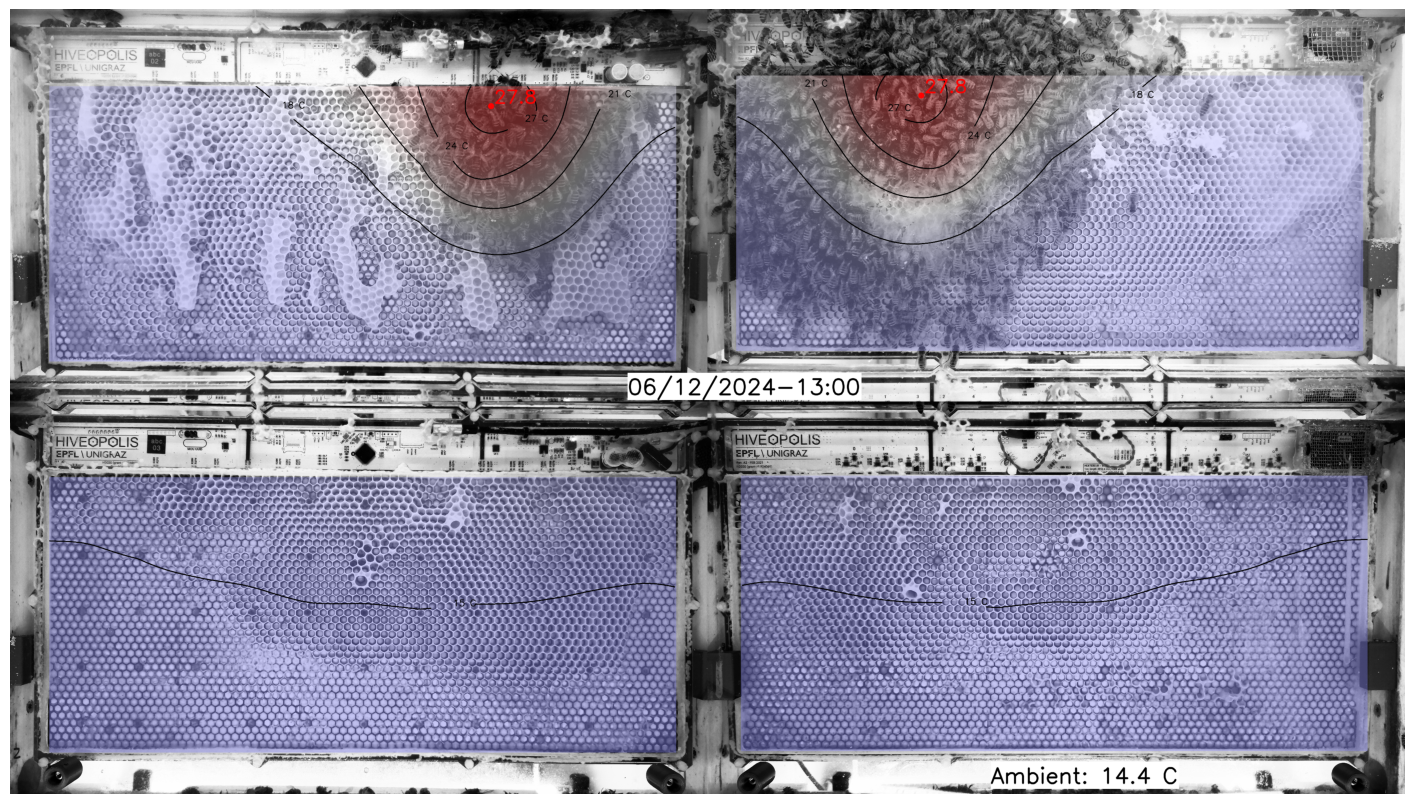

In [9]:
frame = 0 # Frame idx within datetimes
dt = datetimes[frame]
contours = list(range(12, 37, 3))
snapshot = generate_frame(dt, contours=contours)
# For a random time frame, generate the image of the hive and the thermal plot side by side with matplotlib
# This is just to check that everything is working fine
plt.figure(figsize=(18, 12))
plt.imshow(snapshot)
plt.axis('off') 
plt.show()

### Automation

In [10]:
snapshot_0 = generate_frame(datetimes[0], contours=contours)
filename=f"hive{hive_nb}_{first_dt.strftime('%y%m%d-%H%M%Z')}_{last_dt.strftime('%y%m%d-%H%M%Z')}"
# If file exists, add a number to the name
counter = 1
while os.path.isfile(dest+filename+".mp4"):
    print(f"File {filename} already exists. Adding a counter to the filename.")
    filename = f"{filename}_{counter}"
    counter += 1
    
video = initVideoWriter(dest=dest, shape=snapshot_0.shape, name=filename, fps=fps) # RGB video
print("Writing video with dimensions: ", snapshot_0.shape)

for dt in tqdm(datetimes):
    snapshot = generate_frame(dt, contours=contours)
    # Convert from RGB to BGR
    snapshot = cv2.cvtColor(snapshot, cv2.COLOR_RGB2BGR)
    video.write(snapshot)

# Release the VideoWriter object
video.release()
print("Video written successfully.")

# Cleanup step to release resources
multiprocessing.active_children()

File hive2_241206-1200UTC_241213-1000UTC already exists. Adding a counter to the filename.
Writing video with dimensions:  (2160, 3840, 3)


100%|██████████| 399/399 [10:50<00:00,  1.63s/it]

Video written successfully.


[<SpawnProcess name='Dask Worker process (from Nanny)' pid=95641 parent=95615 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=95642 parent=95615 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=95639 parent=95615 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=95640 parent=95615 started daemon>]